✨ 파일 설명: raw data로부터 feature들을 추출하고, 각 feature의 importance 를 계산하여 비교한다.


#1. Import Data

In [ ]:
import pickle
from google.colab import drive
drive.mount('/content/gdrive')

USE_SUBLABEL = False
URL_PER_SITE = 10
TOTAL_URLS   = 950

# Load the pickle file
print("Loading datafile...")
# '/content/gdrive/My Drive/Colab Notebooks/pi_digits.txt'
with open('/content/gdrive/My Drive/Colab Notebooks/mon_standard.pkl', 'rb') as fi: # Path to mon_standard.pkl in Colab
    data = pickle.load(fi)

X1 = [] # Array to store instances (timestamps) - 19,000 instances, e.g., [[0.0, 0.5, 3.4, ...], [0.0, 4.5, ...], [0.0, 1.5, ...], ... [... ,45.8]]
X2 = [] # Array to store instances (direction*size) - size information
y = [] # Array to store the site of each instance - 19,000 instances, e.g., [0, 0, 0, 0, 0, 0, ..., 94, 94, 94, 94, 94]

# Differentiate instances and sites, and store them in the respective x and y arrays
# x array (direction*timestamp), y array (site label)
for i in range(TOTAL_URLS):
    if USE_SUBLABEL:
        label = i
    else:
        label = i // URL_PER_SITE # Calculate which site's URL the current URL being processed belongs to and set that value as the label. Thus, URLs fetched from the same site are labeled identically.
    for sample in data[i]:
        size_seq = []
        time_seq = []
        for c in sample:
            dr = 1 if c > 0 else -1
            time_seq.append(abs(c))
            size_seq.append(dr * 512)
        X1.append(time_seq)
        X2.append(size_seq)
        y.append(label)
size = len(y)

print(f'Total samples: {size}') # Output: 19000


Mounted at /content/gdrive
Loading datafile...
Total samples: 19000


feature를 배열 형태로 추출

In [ ]:
n_pack = [] #Array to store total number of packets
n_in = [] #Array to store number of incoming packets : server -> client (size < 0)
n_out = [] #Array to store number of outgoing packets : client -> server (size > 0)
r_in = [] #Array to store ratio of incoming packets
r_out = [] #Array to store ratio of outcoming packets
in_first = [] #Array to store number of incoming packet in First 30 Packets
out_first = [] #Array to store number of outcoming packet in First 30 Packets
transmission_time = [] #Array to store total transmission time
packets_per_sec = [] #Array to store #of packets per second

for i in range (0,len(X2)):
  count = 0
  count_30 = 0
  for j in range (0,len(X2[i])):
    if X2[i][j] < 0:
      count+=1
      if j < 30: #incoming packet이고 처음 30개 안에 해당된다면
        count_30+=1
  n_pack.append(len(X2[i]))
  n_in.append(count)
  n_out.append(len(X2[i])-count)
  r_in.append(count/len(X2[i]))
  r_out.append(1-count/len(X2[i]))
  in_first.append(count_30)
  out_first.append(30-count_30)
  transmission_time.append(X1[i][-1])
  packets_per_sec.append(len(X2[i])/X1[i][-1])

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

####### 새로 df_mon 이라는 dataframe을 만들었습니다
df_mon = pd.DataFrame({"total packets": n_pack, "#of incoming packets": n_in, "#of outgoing packets": n_out,
                       "ratio of incoming packets": r_in, "ratio of outgoing packets": r_out,
                       "#of incoming(first30)": in_first, "#of outgoing(first30)": out_first, "total time": transmission_time, "#of packets per sec": packets_per_sec, "label": y})


In [ ]:
df_mon.head()

,total packets,#of incoming packets,#of outgoing packets,ratio of incoming packets,ratio of outgoing packets,#of incoming(first30),#of outgoing(first30),total time,#of packets per sec,label
0,1421,1300,121,0.914849,0.085151,21,9,10.14,140.138067,0
1,518,438,80,0.845560,0.154440,22,8,10.16,50.984252,0
2,1358,1240,118,0.913108,0.086892,23,7,11.11,122.232223,0
3,1446,1324,122,0.915629,0.084371,21,9,13.36,108.233533,0
4,1406,1291,115,0.918208,0.081792,22,8,10.64,132.142857,0


# **Grid search to calculate feature importance**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
X = df_mon[df_mon.columns[:-1]]
y = df_mon['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

clf = RandomForestClassifier(n_estimators=20, criterion="entropy", max_depth=10, min_samples_split=2, max_features="sqrt", random_state=0)
# feature간 상대적인 중요도를 확인하기 위해서 parameter는 lab에서 사용한 것을 사용함
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test) #Test the trained model using test data

(15200, 9)
(3800, 9)
(15200,)
(3800,)


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score

y_pred = clf.predict(X_test) #Test the trained model using test data
print("Accuracy on test dataset: {}".format(accuracy_score(y_test, y_pred)))

confusion_matrix(y_test, y_pred)

Accuracy on test dataset: 0.6257894736842106


array([[19,  0,  0, ...,  0,  0,  0],
       [ 0, 24,  2, ...,  0,  0,  0],
       [ 0,  0, 35, ...,  0,  0,  0],
       ...,
       [ 0,  0,  2, ..., 20,  0,  1],
       [ 1,  0,  0, ...,  0, 36,  0],
       [ 0,  0,  0, ...,  0,  0, 22]])

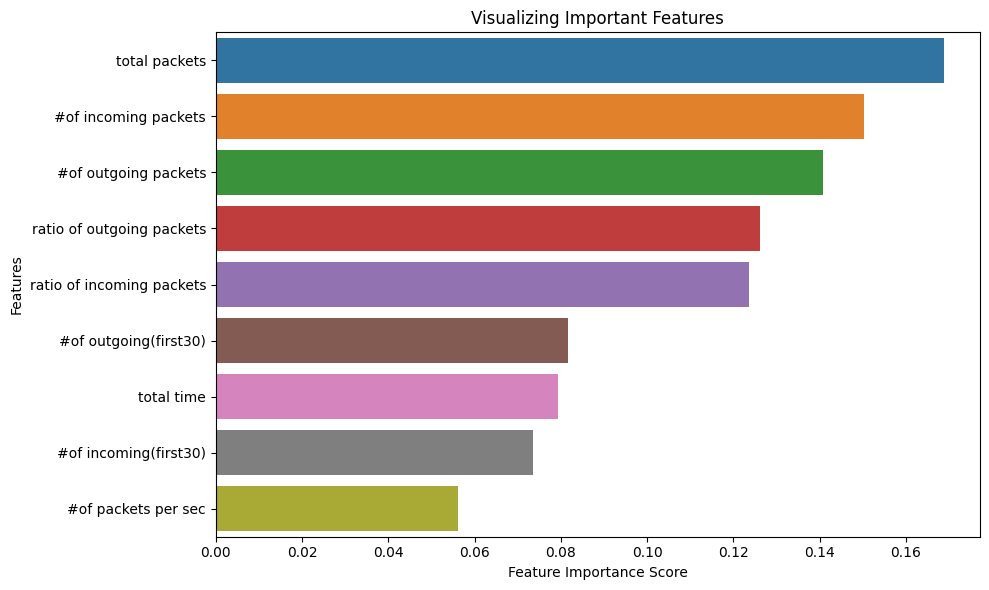

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

feature_imp = pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.tight_layout()

# **1. total packets, #of incoming/outgoing packets**

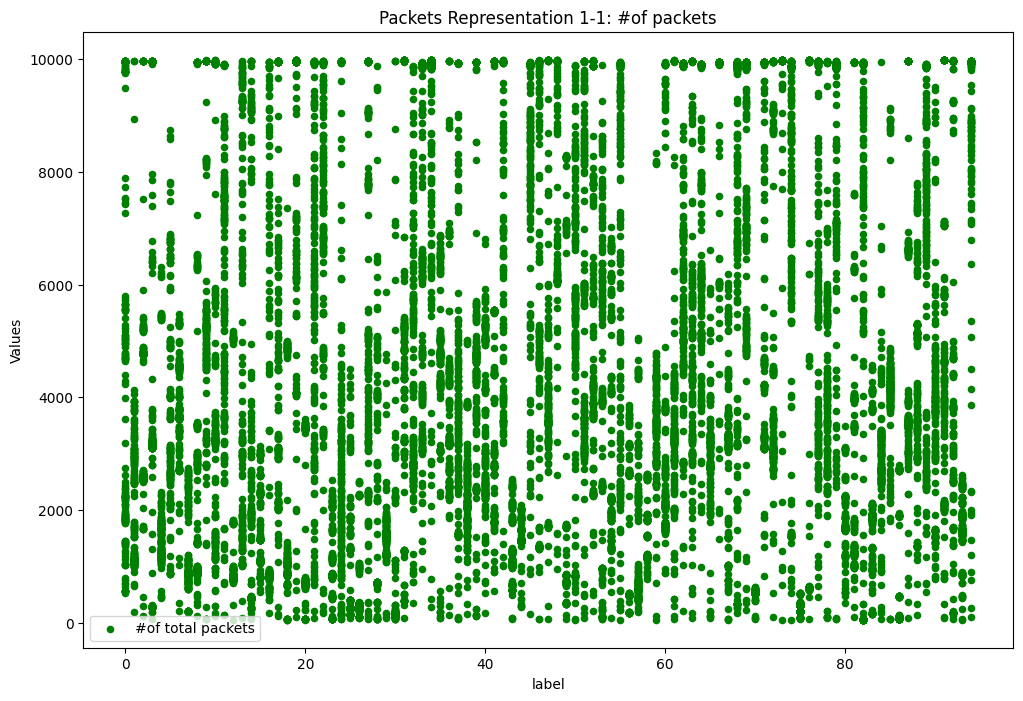

In [ ]:
n_pack = df_mon['total packets']

# 플롯 생성
plt.figure(figsize=(12, 8))
# n_pack (초록색 점)
plt.scatter(labels, n_pack, color='green', label='#of total packets', s=20)

# 플롯 세부 설정
plt.xlabel('label')
plt.ylabel('Values')
plt.title('Packets Representation 1-1: #of packets')
plt.legend()

# 플롯 표시
plt.show()

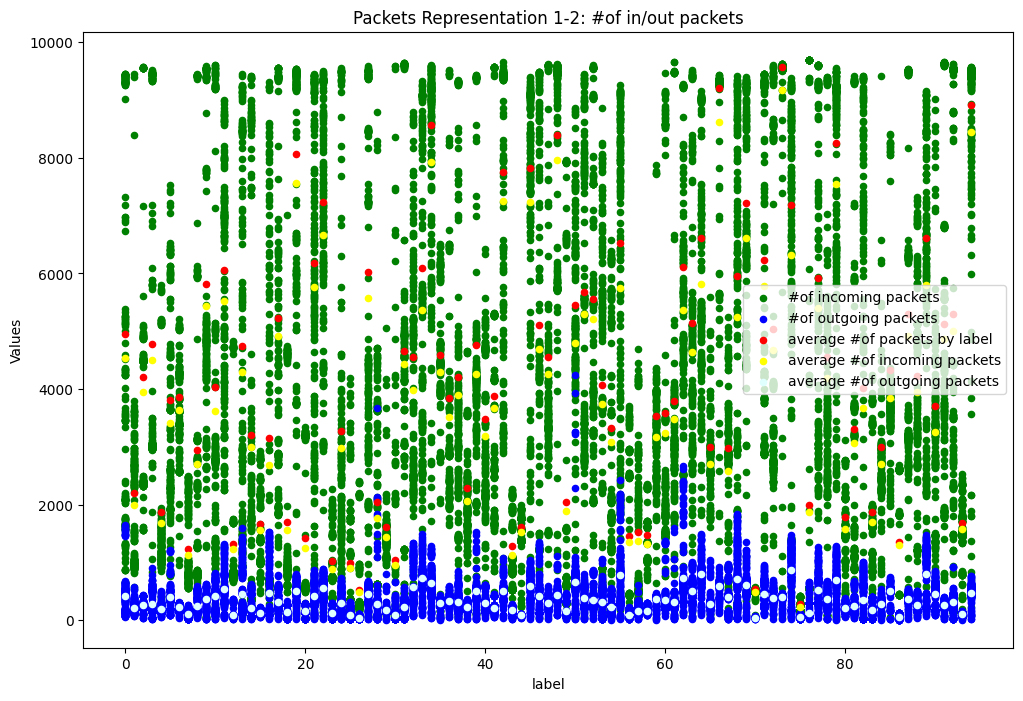

In [ ]:
labels = df_mon['label']
n_pack = df_mon['total packets']
n_in = df_mon['#of incoming packets']
n_out = df_mon['#of outgoing packets']

# 플롯 생성
plt.figure(figsize=(12, 8))

# n_in (초록색 점)
plt.scatter(labels, n_in, color='green', label='#of incoming packets', s=20)

# n_out (파란색 점)
plt.scatter(labels, n_out, color='blue', label='#of outgoing packets', s=20)

# avg_packets_by_label (빨간색 점)
avg_packets_by_label = df_mon.groupby('label')['total packets'].mean()
plt.scatter(avg_packets_by_label.index, avg_packets_by_label.values, color='red', label='average #of packets by label', s=20)

# avg_in_packets_by_label (노란색 점)
avg_in_packets_by_label = df_mon.groupby('label')['#of incoming packets'].mean()
plt.scatter(avg_in_packets_by_label.index, avg_in_packets_by_label.values, color='yellow', label='average #of incoming packets', s=20)

# avg_in_packets_by_label (하늘색 점)
avg_out_packets_by_label = df_mon.groupby('label')['#of outgoing packets'].mean()
plt.scatter(avg_out_packets_by_label.index, avg_out_packets_by_label.values, color='lightcyan', label='average #of outgoing packets', s=20)

# 플롯 세부 설정
plt.xlabel('label')
plt.ylabel('Values')
plt.title('Packets Representation 1-2: #of in/out packets')
plt.legend()

# 플롯 표시
plt.show()

#**2. Ratio of incoming/outgoing packets**

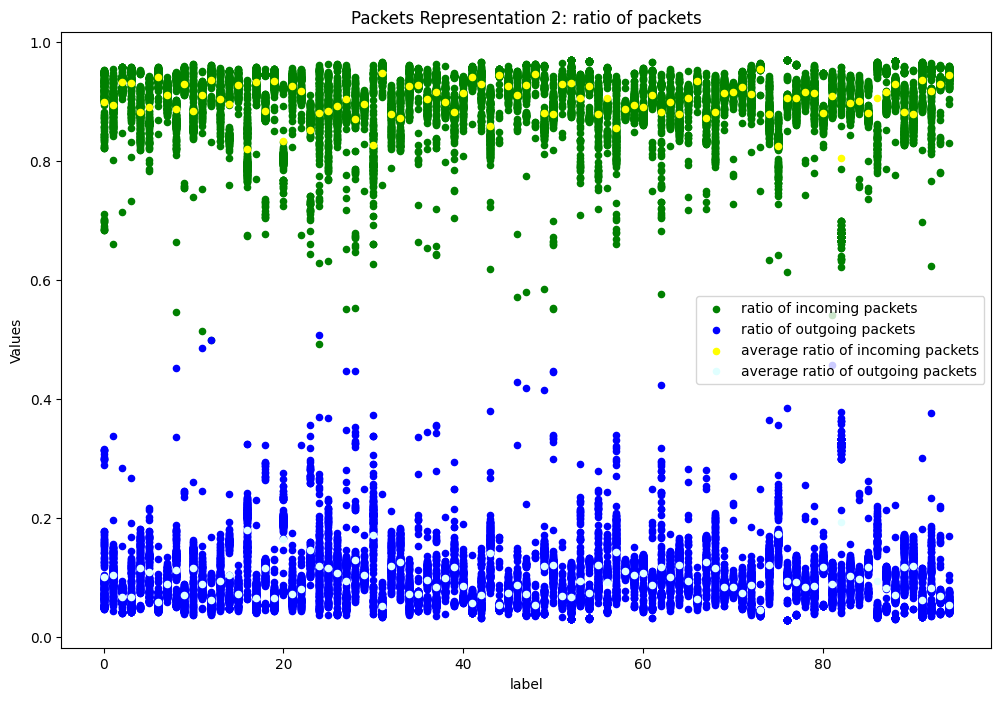

In [ ]:
r_in = df_mon['ratio of incoming packets']
r_out = df_mon['ratio of outgoing packets']

plt.figure(figsize=(12, 8))

# r_in (초록색 점)
plt.scatter(labels, r_in, color='green', label='ratio of incoming packets', s=20)

# r_out (파란색 점)
plt.scatter(labels, r_out, color='blue', label='ratio of outgoing packets', s=20)

#avg_r_in (노란색 점): label별 incoming packet ratio 평균
avg_r_in_by_label = df_mon.groupby('label')['ratio of incoming packets'].mean()
plt.scatter(avg_r_in_by_label.index, avg_r_in_by_label.values, color='yellow', label='average ratio of incoming packets', s=20)

#avg_r_in (하늘색 점): label별 incoming packet ratio 평균
avg_r_out_by_label = df_mon.groupby('label')['ratio of outgoing packets'].mean()
plt.scatter(avg_r_out_by_label.index, avg_r_out_by_label.values, color='lightcyan', label='average ratio of outgoing packets', s=20)

# 플롯 세부 설정
plt.xlabel('label')
plt.ylabel('Values')
plt.title('Packets Representation 2: ratio of packets')
plt.legend()

# 플롯 표시
plt.show()


# **3. First 30 packets**

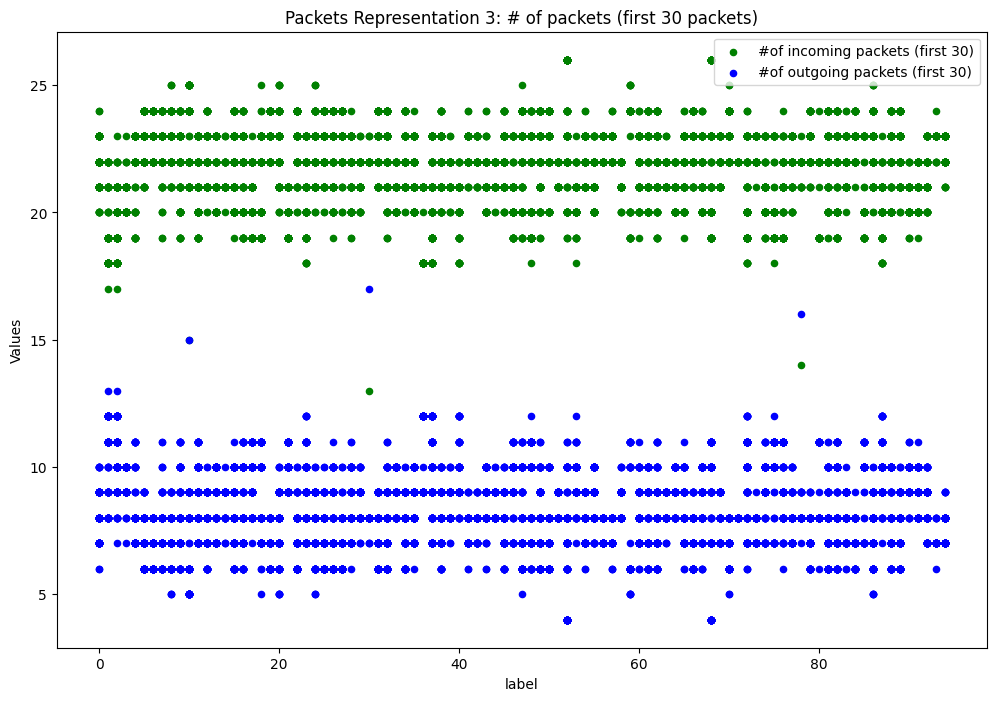

In [ ]:
in_first = df_mon['#of incoming(first30)']
out_first = df_mon['#of outgoing(first30)']

plt.figure(figsize=(12, 8))

# r_in (초록색 점)
plt.scatter(labels, in_first, color='green', label='#of incoming packets (first 30)', s=20)

# r_out (파란색 점)
plt.scatter(labels, out_first, color='blue', label='#of outgoing packets (first 30)', s=20)

# 플롯 세부 설정
plt.xlabel('label')
plt.ylabel('Values')
plt.title('Packets Representation 3: # of packets (first 30 packets)')
plt.legend()

# 플롯 표시
plt.show()

# **4. Total transmission Time**
label별 차이가 적어보임

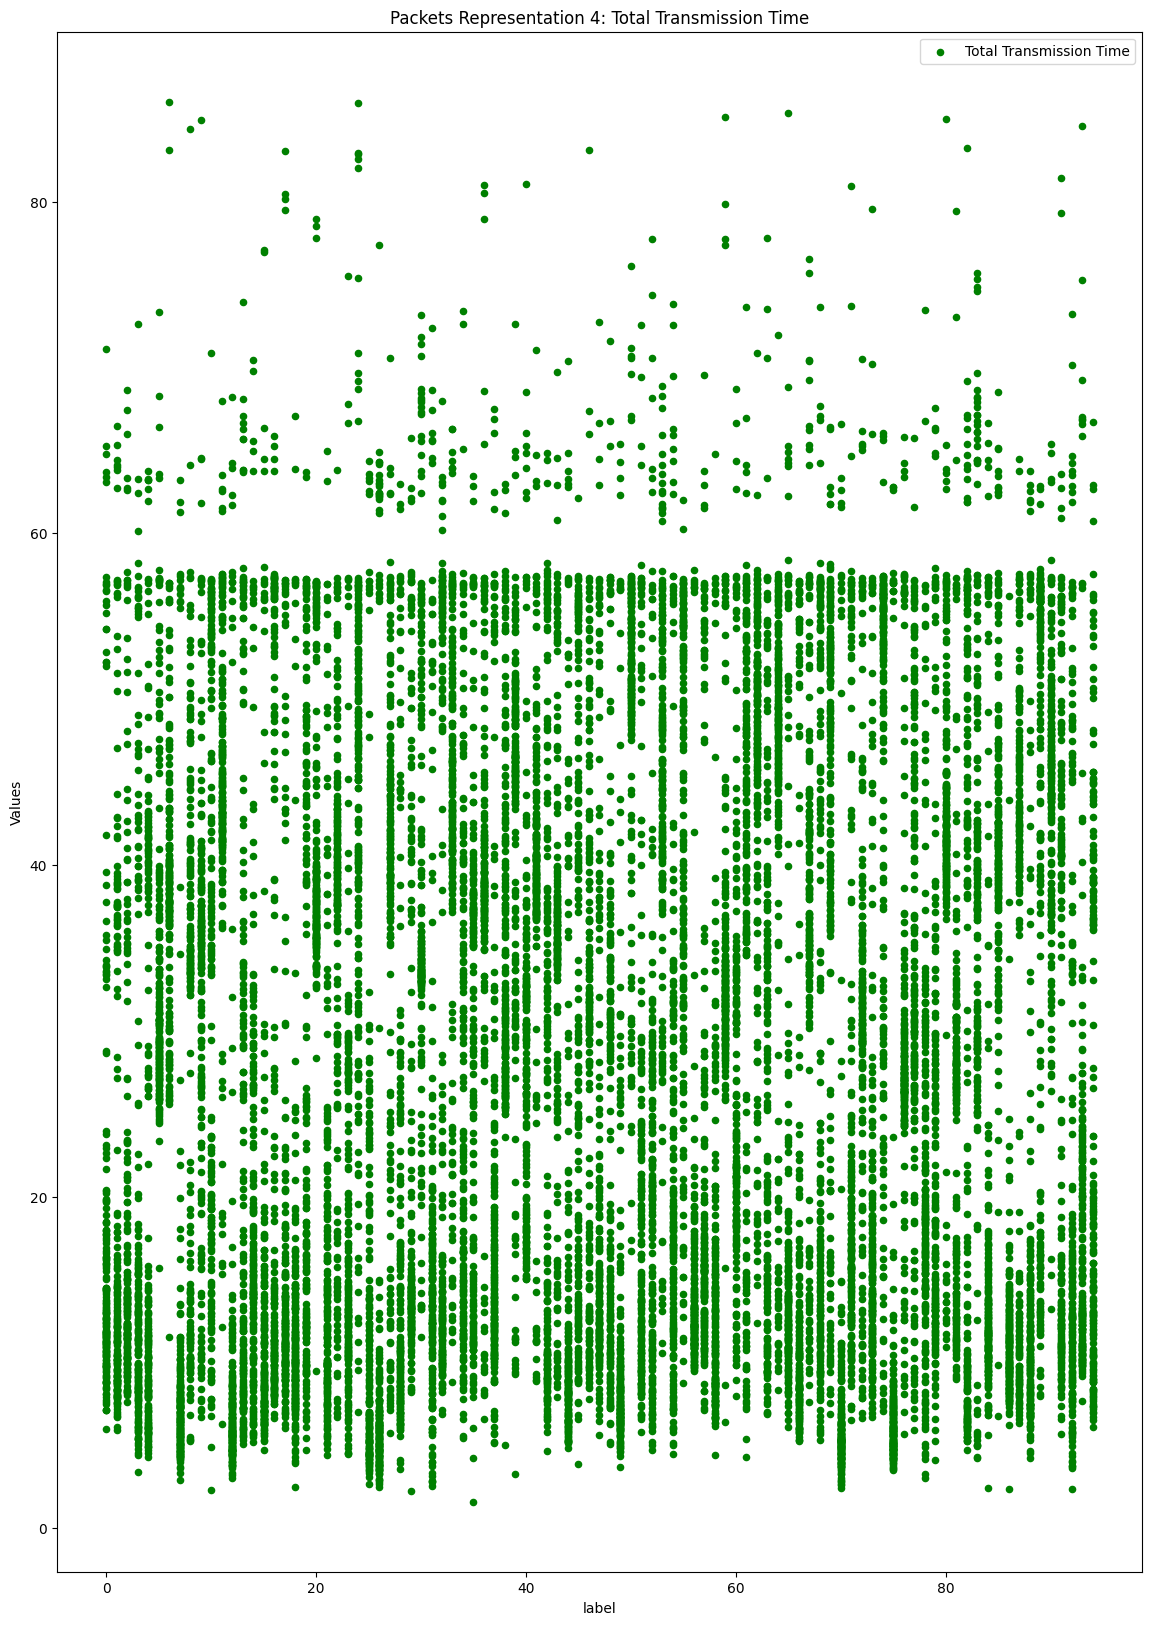

In [ ]:
total_transmission_time = df_mon['total time']

plt.figure(figsize=(14, 20))

# r_in (초록색 점)
plt.scatter(labels, total_transmission_time, color='green', label='Total Transmission Time', s=20)

# 플롯 세부 설정
plt.xlabel('label')
plt.ylabel('Values')
plt.title('Packets Representation 4: Total Transmission Time')
plt.legend()

# 플롯 표시
plt.show()

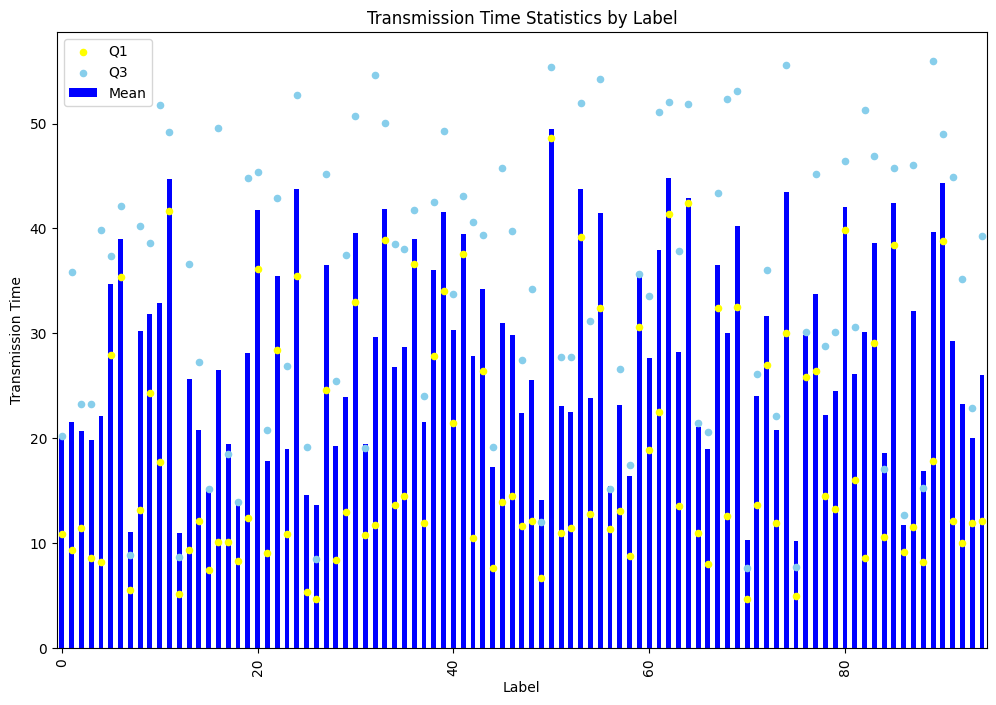

In [ ]:
#import seaborn as sns

# 데이터프레임을 label 별로 그룹화하고 total_transmission_time의 사분위수 계산
quantile_transmission_time = df_mon.groupby('label')['total time'].quantile([0.25, 0.75]).unstack()

# 평균값 시각화
plt.figure(figsize=(12, 8))
mean_transmission_time.plot(kind='bar', color='blue', label='Mean')

# 사분위수 시각화 (Q1, Q3)
plt.scatter(quantile_transmission_time[0.25].index, quantile_transmission_time[0.25], color='yellow', label='Q1', s=20)
plt.scatter(quantile_transmission_time[0.75].index, quantile_transmission_time[0.75], color='skyblue', label='Q3', s=20)

# 플롯 세부 설정
plt.xlabel('Label')
plt.ylabel('Transmission Time')
plt.title('Transmission Time Statistics by Label')
plt.legend()

plt.xticks(range(0, len(mean_transmission_time.index), 20), mean_transmission_time.index[::20])

# 플롯 표시
plt.show()

# **5. Packets per Second**

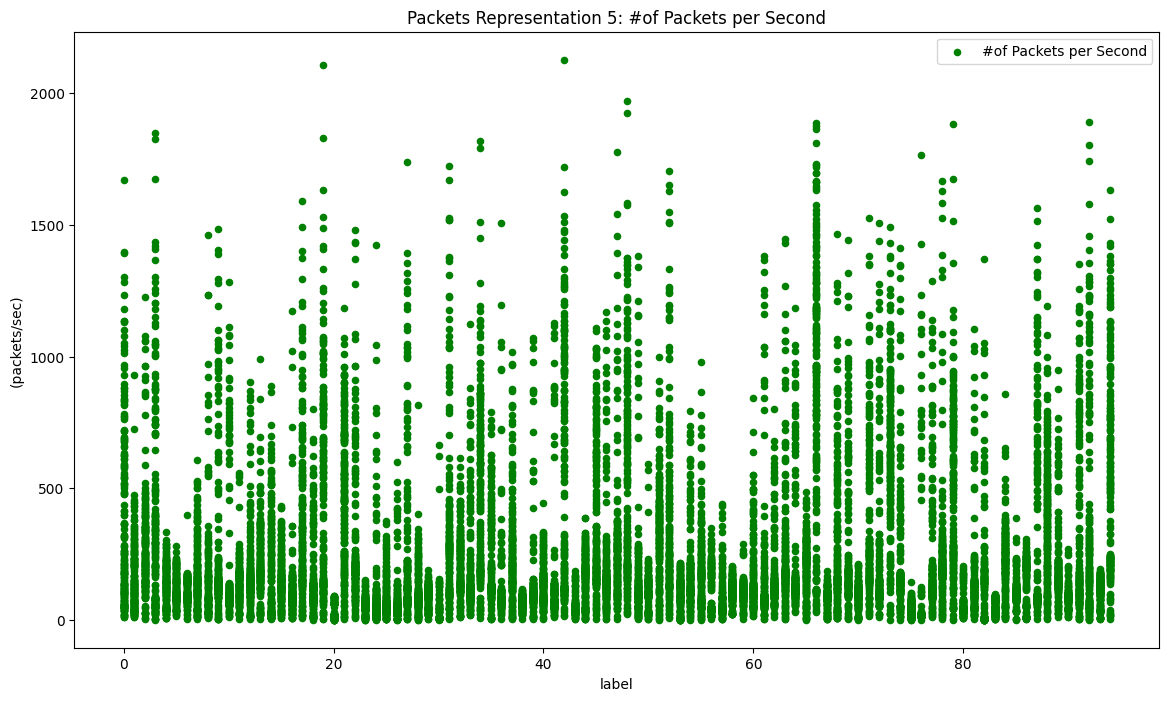

In [ ]:
per_sec = df_mon['#of packets per sec']

plt.figure(figsize=(14, 8))

# r_in (초록색 점)
plt.scatter(labels, per_sec, color='green', label='#of Packets per Second', s=20)

# 플롯 세부 설정
plt.xlabel('label')
plt.ylabel('(packets/sec)')
plt.title('Packets Representation 5: #of Packets per Second')
plt.legend()

# 플롯 표시
plt.show()

# Feature Seclection Test 1 : Random Forest
```
#   feature index
#   0: total packets,	1: #of incoming packets, 2:	#of outgoing packets
#   3: ratio of incoming packets, 4: ratio of outgoing packets
#   5: #of incoming(first30), 6: #of outgoing(first30), 7: total transmission time
#   8: #of packets per sec

# feature importance rank
# 0  > 1 2 >  4 3 >  6 7 5 8
```
## Case 1: All the features
## Case 2: Top 5 feautures
## Case 3: Top 5 features + no.5 + no.6
## Case 4: Top 5 features + no.7 + no.8

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report

In [ ]:
X = df_mon[df_mon.columns[0:-1]] # Case 1: All the features
y = df_mon['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

clf_1 = RandomForestClassifier(n_estimators=100, criterion="entropy", max_depth=10, min_samples_split=2, max_features="sqrt", random_state=0)
clf_1.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=10, random_state=0)

In [ ]:
y_pred1 = clf_1.predict(X_test) #Test the trained model using test data

print("Accuracy on test dataset: {}".format(accuracy_score(y_test, y_pred1)))
precision = precision_score(y_test, y_pred1, average='micro')
print("Precision on test dataset: {}".format(precision))
print(classification_report(y_test, y_pred1, labels=list(range(95))))

Accuracy on test dataset: 0.6428947368421053
Precision on test dataset: 0.6428947368421053
              precision    recall  f1-score   support

           0       0.75      0.55      0.64        38
           1       0.51      0.50      0.51        42
           2       0.71      0.85      0.78        41
           3       0.58      0.72      0.64        40
           4       0.57      0.67      0.62        30
           5       0.61      0.66      0.63        35
           6       0.39      0.82      0.52        33
           7       0.64      0.74      0.69        43
           8       0.72      0.78      0.75        36
           9       0.67      0.60      0.63        52
          10       0.88      0.52      0.66        44
          11       0.50      0.65      0.57        40
          12       0.78      0.90      0.83        39
          13       0.83      0.24      0.38        41
          14       0.79      0.58      0.67        33
          15       0.67      0.75      0.71 

In [ ]:
X = df_mon[df_mon.columns[0:5]] # Case 2: Top 5 features (feature index 0~4)
y = df_mon['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

clf_2 = RandomForestClassifier(n_estimators=100, criterion="entropy", max_depth=10, min_samples_split=2, max_features="sqrt", random_state=0)
clf_2.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=10, random_state=0)

In [ ]:

y_pred2 = clf_2.predict(X_test) #Test the trained model using test data

print("Accuracy on test dataset: {}".format(accuracy_score(y_test, y_pred2)))
precision = precision_score(y_test, y_pred2, average='micro')
print("Precision on test dataset: {}".format(precision))
print(classification_report(y_test, y_pred2, labels=list(range(95))))

Accuracy on test dataset: 0.48947368421052634
Precision on test dataset: 0.48947368421052634
              precision    recall  f1-score   support

           0       0.45      0.39      0.42        38
           1       0.33      0.14      0.20        42
           2       0.61      0.80      0.69        41
           3       0.46      0.53      0.49        40
           4       0.45      0.60      0.51        30
           5       0.44      0.49      0.46        35
           6       0.48      0.67      0.56        33
           7       0.35      0.47      0.40        43
           8       0.50      0.42      0.45        36
           9       0.44      0.40      0.42        52
          10       0.58      0.32      0.41        44
          11       0.55      0.42      0.48        40
          12       0.64      0.82      0.72        39
          13       0.38      0.24      0.30        41
          14       0.50      0.52      0.51        33
          15       0.43      0.62      0.5

In [ ]:
X = df_mon[df_mon.columns[0:7]] # Case 3: Top 5 features + no.5, 6
y = df_mon['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

clf_3 = RandomForestClassifier(n_estimators=100, criterion="entropy", max_depth=10, min_samples_split=2, max_features="sqrt", random_state=0)
clf_3.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=10, random_state=0)

In [ ]:

y_pred3 = clf_3.predict(X_test) #Test the trained model using test data

print("Accuracy on test dataset: {}".format(accuracy_score(y_test, y_pred3)))
precision = precision_score(y_test, y_pred3, average='micro')
print("Precision on test dataset: {}".format(precision))
print(classification_report(y_test, y_pred3, labels=list(range(95))))

Accuracy on test dataset: 0.5839473684210527
Precision on test dataset: 0.5839473684210527
              precision    recall  f1-score   support

           0       0.68      0.39      0.50        38
           1       0.58      0.52      0.55        42
           2       0.73      0.88      0.80        41
           3       0.55      0.70      0.62        40
           4       0.46      0.57      0.51        30
           5       0.59      0.69      0.63        35
           6       0.46      0.67      0.54        33
           7       0.52      0.65      0.58        43
           8       0.69      0.75      0.72        36
           9       0.55      0.52      0.53        52
          10       0.70      0.43      0.54        44
          11       0.51      0.57      0.54        40
          12       0.75      0.85      0.80        39
          13       0.56      0.22      0.32        41
          14       0.57      0.61      0.59        33
          15       0.52      0.72      0.60 

In [ ]:
selected_columns = [0, 1, 2, 3, 4, 7, 8]
X = df_mon.iloc[:, selected_columns]# Case 3: Top 5 features + no.7, 8
y = df_mon['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

clf_4 = RandomForestClassifier(n_estimators=100, criterion="entropy", max_depth=10, min_samples_split=2, max_features="sqrt", random_state=0)
clf_4.fit(X_train, y_train)


RandomForestClassifier(criterion='entropy', max_depth=10, random_state=0)

In [ ]:
y_pred4 = clf_4.predict(X_test) #Test the trained model using test data

print("Accuracy on test dataset: {}".format(accuracy_score(y_test, y_pred4)))
precision = precision_score(y_test, y_pred4, average='micro')
print("Precision on test dataset: {}".format(precision))
print(classification_report(y_test, y_pred4, labels=list(range(95))))

Accuracy on test dataset: 0.5676315789473684
Precision on test dataset: 0.5676315789473684
              precision    recall  f1-score   support

           0       0.59      0.50      0.54        38
           1       0.40      0.14      0.21        42
           2       0.62      0.83      0.71        41
           3       0.51      0.57      0.54        40
           4       0.66      0.70      0.68        30
           5       0.61      0.49      0.54        35
           6       0.49      0.82      0.61        33
           7       0.51      0.60      0.55        43
           8       0.69      0.50      0.58        36
           9       0.62      0.56      0.59        52
          10       0.63      0.39      0.48        44
          11       0.42      0.38      0.39        40
          12       0.74      0.87      0.80        39
          13       0.52      0.34      0.41        41
          14       0.67      0.48      0.56        33
          15       0.61      0.70      0.65 

In [ ]:

print("Accuracy on test1: {}".format(accuracy_score(y_test, y_pred1)))
print("Accuracy on test2: {}".format(accuracy_score(y_test, y_pred2)))
print("Accuracy on test3: {}".format(accuracy_score(y_test, y_pred3)))
print("Accuracy on test4: {}".format(accuracy_score(y_test, y_pred4)))

Accuracy on test1: 0.6428947368421053
Accuracy on test2: 0.48947368421052634
Accuracy on test3: 0.5839473684210527
Accuracy on test4: 0.5676315789473684


# **모든 Feature를 사용하기로 결정!**

# 1. Naive Bayes 결과

In [ ]:
from sklearn.naive_bayes import CategoricalNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

model = CategoricalNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred, labels=list(range(95)))) # 각 라벨 별로 결과 출력
print("accuracy score: ", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.15      0.08      0.10        38
           1       0.16      0.07      0.10        42
           2       0.33      0.24      0.28        41
           3       0.30      0.17      0.22        40
           4       0.19      0.13      0.16        30
           5       0.11      0.17      0.14        35
           6       0.18      0.36      0.24        33
           7       0.50      0.26      0.34        43
           8       0.25      0.22      0.24        36
           9       0.09      0.04      0.05        52
          10       0.23      0.16      0.19        44
          11       0.13      0.17      0.15        40
          12       0.53      0.46      0.49        39
          13       0.00      0.00      0.00        41
          14       0.43      0.30      0.36        33
          15       0.19      0.17      0.18        40
          16       0.23      0.29      0.26        35
          17       0.12    

In [ ]:
from sklearn.tree import DecisionTreeClassifier


Dtree = DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_split=2, random_state=0)
Dtree.fit(X_train, y_train)
y_pred = Dtree.predict(X_test)

print("Accuracy on test dataset: {}".format(accuracy_score(y_test, y_pred)))
precision = precision_score(y_test, y_pred, average='micro')
print("Precision on test dataset: {}".format(precision))
print(classification_report(y_test, y_pred, labels=list(range(95))))

Accuracy on test dataset: 0.48447368421052633
Precision on test dataset: 0.48447368421052633
              precision    recall  f1-score   support

           0       0.36      0.42      0.39        38
           1       0.50      0.21      0.30        42
           2       0.41      0.59      0.48        41
           3       0.48      0.60      0.53        40
           4       0.34      0.67      0.45        30
           5       0.36      0.26      0.30        35
           6       0.56      0.76      0.64        33
           7       0.50      0.40      0.44        43
           8       0.47      0.47      0.47        36
           9       0.44      0.46      0.45        52
          10       0.34      0.36      0.35        44
          11       0.33      0.35      0.34        40
          12       0.60      0.87      0.71        39
          13       0.35      0.22      0.27        41
          14       0.54      0.39      0.46        33
          15       0.40      0.47      0.4